# Autoencoder V1.0.

The following autoencoder is based on the following websites:

 - https://medium.datadriveninvestor.com/covid-19-detection-in-x-ray-images-with-pytorch-5c5602b4658f
 - https://medium.com/pytorch/implementing-an-autoencoder-in-pytorch-19baa22647d1
 - https://gist.github.com/AFAgarap/4f8a8d8edf352271fa06d85ba0361f26#file-autoencoder-pytorch-ipynb
 - https://discuss.pytorch.org/t/how-to-load-images-without-using-imagefolder/59999/2

In [3]:
cd ../

/media/SharedUsers/sdo19/home


In [4]:
cd /media/Data/ComputerVision/mimic_cxr_jpg_small_chest_radiograph/data/physionet.org/files/mimic-cxr-jpg/2.0.0/files

/media/Data/ComputerVision/mimic_cxr_jpg_small_chest_radiograph/data/physionet.org/files/mimic-cxr-jpg/2.0.0/files


In [ ]:
from IPython.display import Image
import os
from PIL import Image as PILIM
#import cv2 #OPENCV, might be a third way to access images?
#FOUND OUT NOT ALL IMAGES ARE SAME SIZE, USUALLY AROUND (2544,3056)
#Found out there are 377110 images
#Below I have 2 diff ways to display images, not sure which one i want, depends on what methods I wanna use? Where am I storing images?


directory="/media/Data/ComputerVision/mimic_cxr_jpg_small_chest_radiograph/data/physionet.org/files/mimic-cxr-jpg/2.0.0/files"
count=0
numimages=0
im_names=[]
name=""
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)  
    if os.path.isdir(f):
        for foldername in os.listdir(f):
            g = os.path.join(f, foldername) 
            if os.path.isdir(g):
                for h in os.listdir(g):
                    k=os.path.join(g,h)
                    if os.path.isdir(k):
                        for image1 in os.listdir(k):
                            impath = os.path.join(k, image1) 
                            if impath.endswith("jpg"):
                                if count<10000:
                                    #2 ways to get image
                                    
                                    #1ST WAY
                                    
                                    #currim=Image(filename=impath,width = 100, height = 100)
                                    #display(currim)
                                    name=impath
                                    if directory in name:
                                        name.replace(directory,'')
                                    im_names.append(name)
                                    
                                    #2ND WAY
                                    
                                    #im3 = PILIM.open(impath)
                                    
                                    #Calculate size, only know how to do it with 2nd way
                                    #size=im3.size
                                    #print(size)
                                    #display(im3)
                                    #listimages.append(im3)
                                    
                                    count+=1
                                numimages+=1
print(im_names[0:10])
print(numimages) #377110 images

In [ ]:
# Import essential libraries
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
#from PIL import Image
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import time
import random
%matplotlib inline

In [ ]:
train_img_name, test_img_name= train_test_split(im_names, test_size=0.2, random_state=50)

In [2]:
class CustomDatasetFromImages(torch.utils.data.Dataset):
    def __init__(self, img_name, transforms=None): 
        self.image_arr = np.asarray(img_name)
        #self.label_arr = np.asarray(label)
        self.data_len = len(img_name)
        self.transforms = transforms
    def __getitem__(self, index):
        single_img_name = self.image_arr[index]
        img_array = PILIM.open(single_img_name).convert('RGB') #THIS IS ASKING TO OPEN BEFORE I TRANSFORM?? is that it?  nope
        if self.transforms is not None:   #I HAD Image.open, but i import image as PILIM(see above)
            img_array = self.transforms(img_array)
        #image_label = self.label_arr[index]
        return (single_img_name, img_array)
    def __len__(self):
        return self.data_len

NameError: name 'torch' is not defined

In [ ]:
#class CustomDatasetFromImages(torch.utils.data.Dataset):
    #def __init__(self, img_name, transforms=None): 
       # self.image_arr = np.asarray(img_name)
        #self.label_arr = np.asarray(label)
        #self.data_len = len(img_name)
        #self.transforms = transforms
   # def __getitem__(self, index):
        #single_img_name = self.image_arr[index]
        #img_array = Image.open(single_img_name).convert('RGB')
       # if self.transforms is not None:
            #img_array = self.transforms(img_array)
        #image_label = self.label_arr[index]
        #tensor_image = self.transform(image)
        #return tensor_image
   # def __len__(self):
        #return self.data_len

In [ ]:
train_Aug = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)),
                                            torchvision.transforms.RandomRotation((-20, 20)),
                                            #torchvision.transforms.RandomAffine(0, translate=None, scale=[0.7, 1.3], shear=None, resample=False, fillcolor=0),
                                            torchvision.transforms.ToTensor()])
test_Aug = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)),torchvision.transforms.ToTensor()])

In [ ]:
train_set=CustomDatasetFromImages(train_img_name, transforms=train_Aug)
test_set=CustomDatasetFromImages(test_img_name, transforms=test_Aug)
trainloader= torch.utils.data.DataLoader(train_set, batch_size=64, num_workers=2,shuffle=True) 
testloader= torch.utils.data.DataLoader(test_set, batch_size=64, num_workers=2, shuffle=False)

In [ ]:
import torch.nn as nn
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.sigmoid(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.sigmoid(activation)
        return reconstructed

In [ ]:
epochs = 1
learning_rate = 1e-3

In [ ]:
import torch.optim as optim
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=50176).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# mean-squared error loss
criterion = nn.MSELoss()

In [ ]:
for epoch in range(epochs):
    loss = 0
    for _,batch_features in trainloader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.view(-1, 50176).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(trainloader)
    
    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))

In [ ]:
with torch.no_grad():
    for _,batch_features in testloader:
        batch_features = batch_features[0:50]
        test_examples = batch_features.view(-1, 50176)
        reconstruction = model(test_examples)
        break

In [ ]:
with torch.no_grad():
    number = 50
    #plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        #ax = plt.subplot(2, number, index + 1)
        plt.figure()
        plt.imshow(test_examples[index].numpy().reshape(224, 224))
        plt.gray()
        #ax.get_xaxis().set_visible(False)
        #ax.get_yaxis().set_visible(False)

        # display reconstruction
        #ax = plt.subplot(2, number, index + 1 + number)
        plt.figure()
        plt.imshow(reconstruction[index].numpy().reshape(224, 224))
        plt.gray()
        #ax.get_xaxis().set_visible(False)
        #ax.get_yaxis().set_visible(False)
    plt.show()
                    


### Examples of outputs

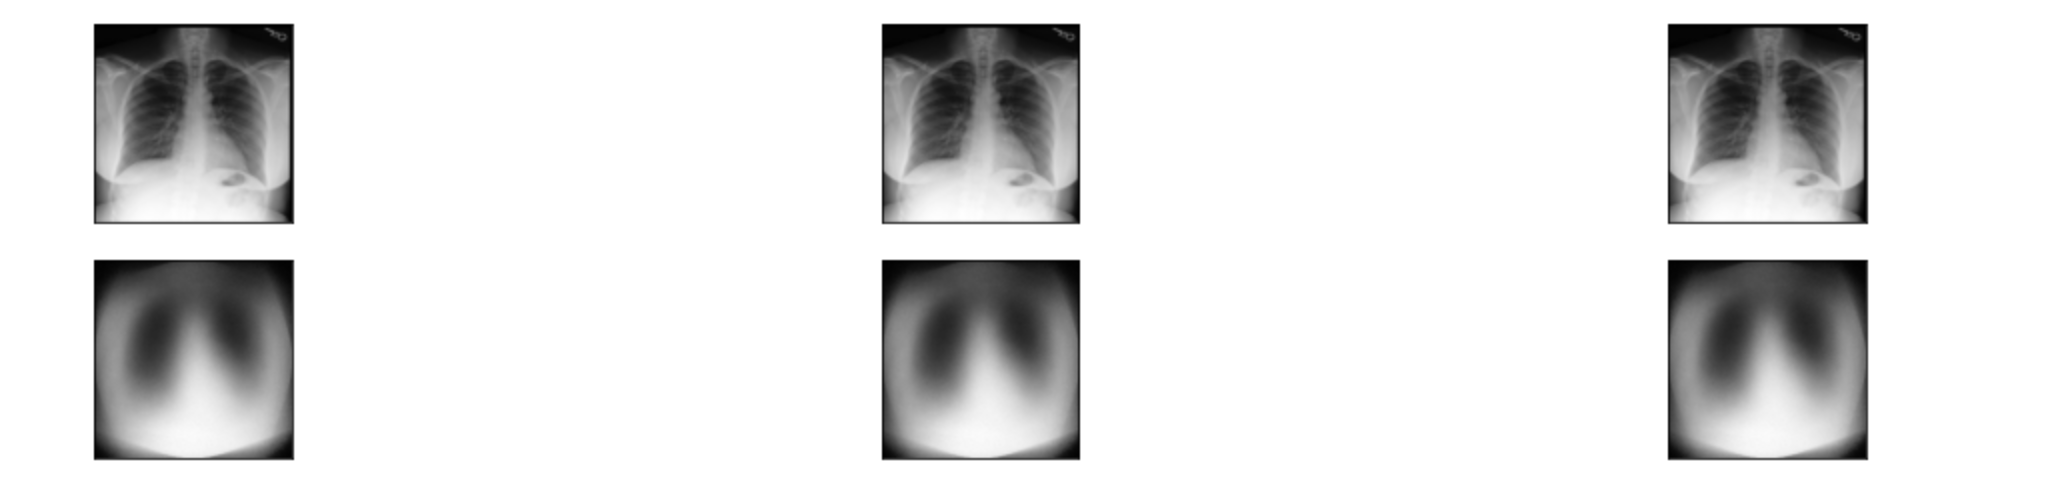

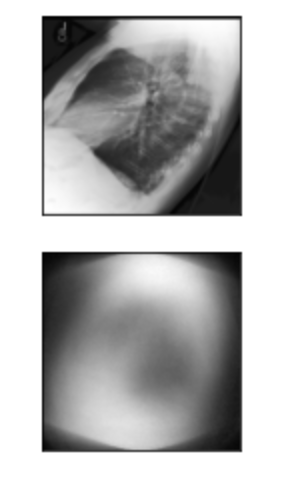